<a href="https://colab.research.google.com/github/samridh10exe/BrailleVision/blob/main/O1Samridh's_Copy_of_assignment_mean_connect4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adversarial Search: Playing "Mean" Connect 4


## Instructions

Name: [Add your name]

I understand that my submission needs to be my own work: [enter 'yes']

Points: 10


---



## Introduction

You will implement different versions of agents that play "Mean" Connect 4:

> "Connect 4 is a two-player connection board game, in which the players choose a color and then take turns dropping colored discs into a seven-column, six-row vertically suspended grid. The pieces fall straight down, occupying the lowest available space within the column. The objective of the game is to be the first to form a horizontal, vertical, or diagonal line of four of one's own discs." (see [Connect Four on Wikipedia](https://en.wikipedia.org/wiki/Connect_Four))

> **The mean part:** This game has an additional rule. Every time it is a player's turn, the player can decide to instead of playing a new disk, take a bottom row disk of the opponent and place it back in the top of the same column. All disks above the removed disk will fall down one position and the removed one will be placed on top. Note that a player can only move an _opponent's disc_ that is in the _bottom row_ of the board. **Further, you are not allowed to play a mean move if your opponent just played one.** This ensures the game will end at some point. This also may affect the definition of a state, compared with standard Connect 4.

If a mean move causes both players to win, the game immediately ends and it is a tie, even if one player has more connect-4s than the other one. If a mean move causes one player to win, then the game also ends and the player with the connect-4 is the winner.

Note that normal [Connect-4 has been solved](https://en.wikipedia.org/wiki/Connect_Four#Mathematical_solution)
in 1988. A connect-4 solver with a discussion of how to solve different parts of the problem can be found here: https://connect4.gamesolver.org/en/

## Task 1: Defining the Search Problem [1 point]

Define the components of the search problem associated with this game:

* Initial state
* Actions
* Transition model
* Test for the terminal state
* Utility for terminal states

In [ ]:
# Your code/answer goes here.

How big is the state space? Give an estimate and explain it.

In [ ]:
# Your code/ answer goes here.

How big is the game tree that minimax search will go through? Give an estimate and explain it.

In [ ]:
# Your code/ answer goes here.

## Task 2: Game Environment and Random Agent [3 point]

You can use a numpy character array as the board. Note that the following function can create boards of different sizes.

In [1]:
import numpy as np
import random
import time
import matplotlib.pyplot as plt


def empty_board(rows=6, cols=7):
    return np.zeros((rows, cols), dtype=int)

print(empty_board())

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]


Instead of colors (red and yellow), you can use 1 and -1 to represent the players Max and Min. Make sure that your agent functions all have the from: `agent_type(state, player = 1)`, where board is the current board position and player is the player (1, -1) whose next move it is and who the agent should play.

Visualization code by Randolph Rankin:

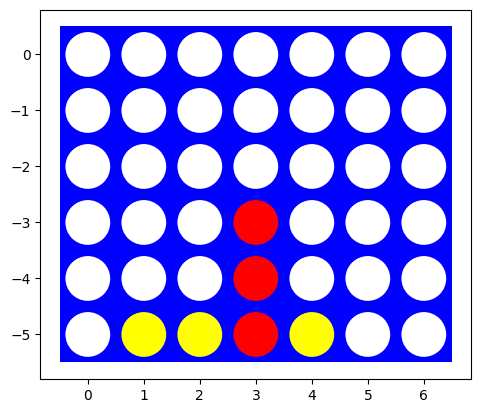

In [2]:
def visualize(board):
    plt.axes()
    rectangle=plt.Rectangle((-0.5,len(board)*-1+0.5),len(board[0]),len(board),fc='blue')
    circles=[]
    for i,row in enumerate(board):
        for j,val in enumerate(row):
            color='white' if val==0 else 'red' if val==1 else 'yellow'
            circles.append(plt.Circle((j,i*-1),0.4,fc=color))

    plt.gca().add_patch(rectangle)
    for circle in circles:
        plt.gca().add_patch(circle)

    plt.axis('scaled')
    plt.show()

board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0,-1,-1, 1,-1, 0, 0]]

visualize(board)

Implement helper functions for:

* The transition model $result(s, a)$.
* The utility function $utility(s)$.
* Check for terminal states $terminal(s)$.
* A check for available actions in each state $actions(s)$.

Make sure that all these functions work with boards of different sizes (number of columns and rows).

In [45]:
import numpy as np
import random

def empty_board(rows=6, cols=7):
    """
    Create and return an empty board of shape (rows x cols).
    0 indicates an empty cell.
    1 indicates a disc belonging to Max (the 'red' player).
    -1 indicates a disc belonging to Min (the 'yellow' player).
    """
    return np.zeros((rows, cols), dtype=int)


def check_connect_four(board, player):
    """
    Checks if 'player' (1 or -1) has a connect-4 in the given board.
    Returns True if yes, False otherwise.

    We look for 4 consecutive discs belonging to 'player'
    in any row, column or diagonal.
    """
    rows, cols = board.shape
    for r in range(rows):
        for c in range(cols):
            if board[r, c] == player:
                # Check horizontal (need c+3 < cols)
                if c + 3 < cols and all(board[r, c + i] == player for i in range(4)):
                    return True
                # Check vertical (need r+3 < rows)
                if r + 3 < rows and all(board[r + i, c] == player for i in range(4)):
                    return True
                # Check diagonal (down-right)
                if (r + 3 < rows and c + 3 < cols
                    and all(board[r + i, c + i] == player for i in range(4))):
                    return True
                # Check diagonal (down-left)
                if (r + 3 < rows and c - 3 >= 0
                    and all(board[r + i, c - i] == player for i in range(4))):
                    return True
    return False


def utility(board):
    """
    Determine if the board is in a winning or tying terminal state:
      - +1 if ONLY player=1 (Max) has a connect-4
      - -1 if ONLY player=-1 (Min) has a connect-4
      -  0 if neither or BOTH players have connect-4 (tie)
    Returns None if no one has connect-4 yet.

    Note on Mean Connect-4:
    If a mean move causes both players to simultaneously have connect-4,
    we regard that as a tie => return 0.
    """
    max_has = check_connect_four(board, 1)
    min_has = check_connect_four(board, -1)
    if max_has and not min_has:
        return 1
    elif min_has and not max_has:
        return -1
    elif max_has and min_has:
        # Both formed connect-4 => tie
        return 0
    else:
        # No connect-4 for either side yet
        return None


def is_full(board):
    """
    Check if the entire board is occupied (no zeros).
    """
    return not np.any(board == 0)


def actions(board, player, last_move_was_mean):
    """
    Return a list of valid actions for the current player.
    An action is a tuple: ("drop", col) or ("mean", col).

    'drop' means: place the player's piece in the top available row
                  of column 'col'.
    'mean' means: if the bottom cell of column 'col' holds
                  the OPPONENT's piece (i.e., -player),
                  remove it and re-insert it at the top of the same column,
                  shifting everything else in that column down by one.

    Only allowed to do a "mean" move if the opponent did NOT just do a mean move
    (i.e., if last_move_was_mean == False). This enforces no consecutive mean moves.
    """
    rows, cols = board.shape
    valid_acts = []

    # 1) Normal drop moves
    for c in range(cols):
        if board[0, c] == 0:  # topmost cell empty => can drop
            valid_acts.append(("drop", c))

    # 2) Mean move
    # Allowed only if last_move_was_mean == False and the bottom cell has an opponent disc
    if not last_move_was_mean:
        for c in range(cols):
            if board[rows - 1, c] == -player:
                valid_acts.append(("mean", c))

    return valid_acts


def result(board, player, action, last_move_was_mean):
    """
    Return (new_board, new_last_mean) after applying 'action' for 'player'.
    'board' is unchanged (we copy it).
    """
    rows, cols = board.shape
    new_board = board.copy()

    act_type, col = action
    if act_type == "drop":
        # Find the lowest empty row in column col
        for r in range(rows - 1, -1, -1):
            if new_board[r, col] == 0:
                new_board[r, col] = player
                break
        return new_board, False  # after a normal drop, last_move_was_mean = False

    else:  # "mean" move
        # Must have the bottom cell as the opponent's disc
        bottom_piece = new_board[rows - 1, col]
        if bottom_piece != -player:
            raise ValueError("Invalid mean move: bottom cell is not the opponent's disc!")

        # Remove the bottom piece, shift column down, place removed piece on top
        removed_disc = bottom_piece
        for r in range(rows - 1, 0, -1):
            new_board[r, col] = new_board[r - 1, col]
        new_board[0, col] = removed_disc # nwxt available space

        return new_board, True  # after a mean move, last_move_was_mean = True


def terminal(board, last_move_was_mean, player):
    """
    Check if the current state is terminal for the CURRENT player's turn.

    A state is terminal if:
      1) The utility(...) is not None => a connect-4 is found (or tie if both).
      2) The board is completely full => no further moves => terminal.
      3) The current player has NO valid actions => the game ends immediately.
         (this is a standard approach in Connect-4 if you cannot move,
          though you can tweak if you want to 'skip' instead).
    """
    # 1) If anyone has connect-4 (or both => tie), the game ends
    u = utility(board)
    if u is not None:
        return True

    # 2) If the board is completely full => no moves => terminal
    if is_full(board):
        return True

    # 3) If the current player has no valid actions => game ends
    possible = actions(board, player, last_move_was_mean)
    if len(possible) == 0:
        return True

    return False


Implement an agent that plays randomly. Make sure the agent function receives as the percept the game state and returns a valid action. Use an agent function definition with the following signature (arguments):

`def random_player(state, player = None): ...`

The argument `player` is used for agents that do not store what side they are playing. The value passed on by the environment should be 1 ot -1 for playerred and yellow, respectively.  See [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) for an example.

In [46]:
def random_player(state, player):
    """A simple random agent that picks a random valid move."""
    board, last_move_was_mean = state
    valid_moves = actions(board, player, last_move_was_mean)
    return random.choice(valid_moves) if valid_moves else None


Let two random agents play against each other 1000 times. Look at the [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) to see how the environment uses the agent functions to play against each other.

How often does each player win? Is the result expected?

In [47]:
def play_game(agent1, agent2, rows=6, cols=7, n_games=1, verbose=False):
    """
    Plays n_games of Mean Connect 4 between agent1 (Max=1) and agent2 (Min=-1).
    Returns counts of outcomes {1: #MaxWins, -1: #MinWins, 0: #Ties}.
    """
    results = {1: 0, -1: 0, 0: 0}
    for g in range(n_games):
        board = empty_board(rows, cols)
        last_mean = False
        player = 1  # Max starts
        while True:
            if terminal(board, last_mean, player):
                u = utility(board)
                if u is None:
                    results[0] += 1
                else:
                    results[u] += 1
                break

            valid_moves = actions(board, player, last_mean)
            if not valid_moves:
                results[0] += 1  # Tie if no valid moves left
                break

            act = agent1((board, last_mean), player) if player == 1 else agent2((board, last_mean), player)
            board, last_mean = result(board, player, act, last_mean)
            player = -player

        if verbose and (g + 1) % 100 == 0:
            print(f"Game {g + 1} finished.")

    return results

In [48]:
# Let two random agents play 1000 times
res = play_game(random_player, random_player, n_games=1000)
print("Random vs. Random over 1000 games:", res)

Random vs. Random over 1000 games: {1: 448, -1: 284, 0: 268}


In [ ]:
# ###############################################################################
# # Experiment: random vs. random
# ###############################################################################

# def experiment_random_vs_random(n=1000, rows=6, cols=7, connect=4):
#     results = {1: 0, -1: 0, 0: 0}
#     for _ in range(n):
#         w = play_game(random_player, random_player, rows, cols, connect, False)
#         results[w] += 1
#     return results

# if __name__ == "__main__":
#     # Example: let random agents play 1000 times
#     results = experiment_random_vs_random(n=1000, rows=6, cols=7, connect=4)
#     print("Random vs. Random Results (1000 games):", results)

## Task 3: Minimax Search with Alpha-Beta Pruning [3 points]

### Implement the search starting.

Implement the search starting from a given state and specifying the player and put it into an agent function.
You can use code from the [tic-tac-toe example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_alpha_beta_tree_search.ipynb).

__Notes:__
* Make sure that all your agent functions have a signature consistent with the random agent above.
* The search space for a $6 \times 7$ board is large. You can experiment with smaller boards (the smallest is $4 \times 4$) and/or changing the winning rule to connect 3 instead of 4.

In [49]:
import math
import sys

def alphabeta(state, depth, alpha, beta, maximizingPlayer):
    """
    Standard alpha-beta minimax:
      state = (board, last_mean)
      depth is how deep we can still search
      alpha, beta as usual
      maximizingPlayer is a boolean (True => next move is from Max=1, else Min=-1)

    Returns (value, action)
    """
    (board, last_mean) = state
    current_player = 1 if maximizingPlayer else -1
    # Check for terminal or depth=0
    if terminal(board, last_mean, current_player):
        # if terminal, use utility
        u = utility(board)
        if u is None:
            # tie at a terminal
            return (0, None)
        else:
            return (u, None)
    if depth == 0:
        # No more search allowed, fallback to a simple evaluation
        return (simple_heuristic(board), None)

    if maximizingPlayer:
        player = 1
        value = -math.inf
        best_action = None

        all_actions = actions(board, player, last_mean)
        # Basic: no move-ordering
        for act in all_actions:
            child_state = result(board, player, act, last_mean)
            (child_val, _) = alphabeta(child_state, depth-1, alpha, beta, False)
            if child_val > value:
                value = child_val
                best_action = act
            alpha = max(alpha, value)
            if alpha >= beta:
                break
        return (value, best_action)
    else:
        player = -1
        value = math.inf
        best_action = None

        all_actions = actions(board, player, last_mean)
        for act in all_actions:
            child_state = result(board, player, act, last_mean)
            (child_val, _) = alphabeta(child_state, depth-1, alpha, beta, True)
            if child_val < value:
                value = child_val
                best_action = act
            beta = min(beta, value)
            if beta <= alpha:
                break
        return (value, best_action)


def simple_heuristic(board):
    """
    A trivial fallback evaluation if needed.
    For example, count #1 discs minus #(-1) discs.
    """
    return np.sum(board)
def minimax_agent(state, player=1, depth=4):
    """
    Uses alpha-beta minimax from perspective of player=1.
    If 'player' is -1, we flip the sign on the returned value
    to get the best move for -1.

    For the action choice, we only care about the best_action from alphabeta.
    """
    # If player = -1, we effectively want to run the same code
    # but treat "maximizingPlayer" = False at the root.

    (board, last_mean) = state

    if player == 1:
        maximizing = True
    else:
        maximizing = False

    val, act = alphabeta(state, depth, -math.inf, math.inf, maximizing)
    return act


Experiment with some manually created boards (at least 5) to check if the agent spots winning opportunities.

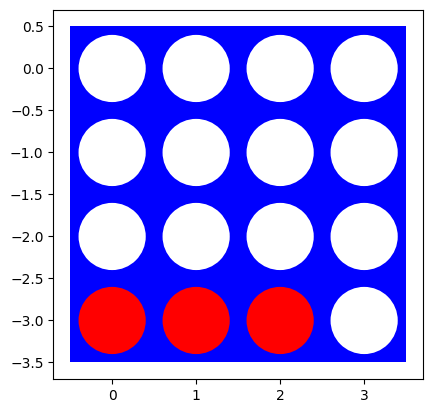

Chosen action by minimax (player=1): ('drop', 0)


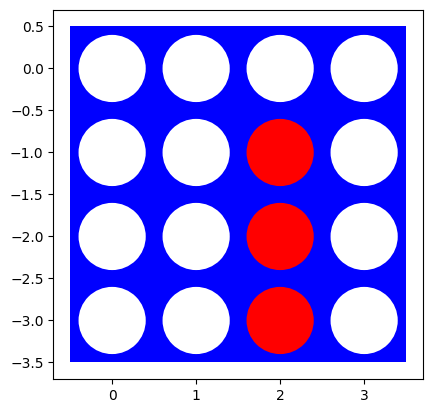

Chosen action by minimax (player=1): ('drop', 0)


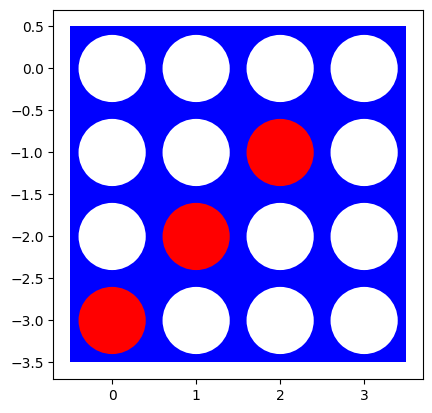

Chosen action by minimax (player=1): ('drop', 0)


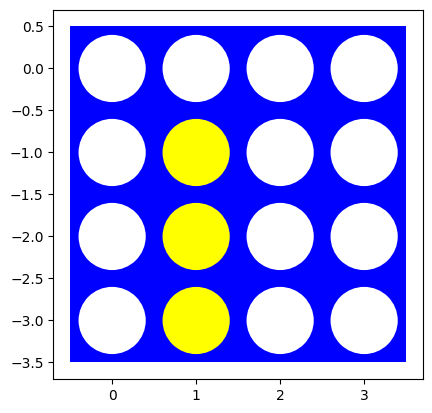

Chosen action by minimax (player=1): ('drop', 0)


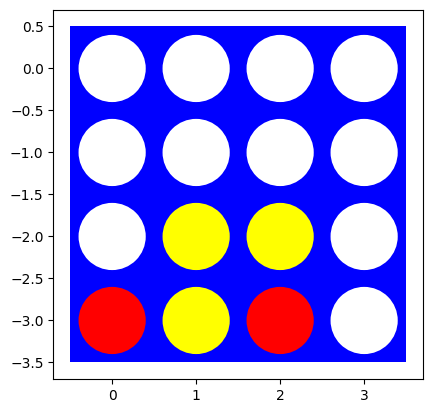

Chosen action by minimax (player=1): ('drop', 0)


In [50]:
def show_and_decide(board, last_mean=False, current_player=1, depth=5):
    """
    1. Visualize the board
    2. Call minimax_agent to get the best move
    3. Print the move
    """
    visualize(board)
    best_action = minimax_agent((board.copy(), last_mean), player=current_player, depth=depth)
    print(f"Chosen action by minimax (player={current_player}): {best_action}")
# Board: 4x4
# Bottom row is [1, 1, 1, 0], everything above is 0.
test1 = empty_board(4,4)
test1[3,0] = 1
test1[3,1] = 1
test1[3,2] = 1
# next move in col=3 should be a horizontal Connect-4 for red.

show_and_decide(test1, last_mean=False, current_player=1, depth=5)
# We create a board with 3 red pieces stacked in one column (say col=2),
# so the 4th will produce a vertical win.
test2 = empty_board(4,4)
test2[3,2] = 1
test2[2,2] = 1
test2[1,2] = 1
# Next drop in col=2 at row=0 is an immediate vertical win.

show_and_decide(test2, last_mean=False, current_player=1, depth=5)
# We arrange three red in a diagonal:
#   row=3,col=0 -> red
#   row=2,col=1 -> red
#   row=1,col=2 -> red
# Next drop at row=0,col=3 completes the diagonal
test3 = empty_board(4,4)
test3[3,0] = 1
test3[2,1] = 1
test3[1,2] = 1
show_and_decide(test3, last_mean=False, current_player=1, depth=5)
# Opponent (yellow = -1) is about to win with a vertical stack in col=1.
# The bottom 3 cells in col=1 are [-1, -1, -1].
test4 = empty_board(4,4)
test4[3,1] = -1
test4[2,1] = -1
test4[1,1] = -1

# It's Red's turn (player=1). If Red doesn't drop a piece on col=1 row=0,
# then Yellow will drop on col=1 next turn and get 4 in a row vertically.

show_and_decide(test4, last_mean=False, current_player=1, depth=5)
# A partially filled 4x4 board with no immediate 3 in a row.
# We'll put some scattered red(1) and yellow(-1) discs.
test5 = empty_board(4,4)
test5[3,0] = 1
test5[3,1] = -1
test5[3,2] = 1
test5[2,1] = -1
test5[2,2] = -1
# Now it's Red's turn. No immediate forced connect-4 in one move.

show_and_decide(test5, last_mean=False, current_player=1, depth=5)


How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [51]:
start_time = time.time()
act = minimax_agent((test_board, False), player=1, depth=5)
end_time = time.time()
print("Action:", act, "Time for move:", end_time - start_time, "seconds")


Action: ('drop', 0) Time for move: 0.006124258041381836 seconds


### Move ordering

Starting the search with better moves will increase the efficiency of alpha-beta pruning. Describe and implement a simple move ordering strategy. Make a table that shows how the ordering strategies influence the time it takes to make a move.

In [52]:
def move_ordering(board, player, last_mean):
    """
    Return a list of actions sorted by a shallow or domain-based heuristic.
    Example: center columns first.
    """
    acts = actions(board, player, last_mean)
    # Sort by how close col is to middle
    cols = board.shape[1]
    mid = (cols - 1) / 2
    # If it's a drop, we can rank by |col - mid|.
    # For mean moves, do the same or slightly less priority.

    def col_priority(a):
        _, c = a
        return abs(c - mid)

    acts_sorted = sorted(acts, key=col_priority)
    return acts_sorted
import math
import sys

def alphabeta(state, depth, alpha, beta, maximizingPlayer):
    """
    Standard alpha-beta minimax:
      state = (board, last_mean)
      depth is how deep we can still search
      alpha, beta as usual
      maximizingPlayer is a boolean (True => next move is from Max=1, else Min=-1)

    Returns (value, action)
    """
    (board, last_mean) = state
    current_player = 1 if maximizingPlayer else -1
    # Check for terminal or depth=0
    if terminal(board, last_mean,current_player):
        # if terminal, use utility
        u = utility(board)
        if u is None:
            # tie at a terminal
            return (0, None)
        else:
            return (u, None)
    if depth == 0:
        # No more search allowed, fallback to a simple evaluation
        return (simple_heuristic(board), None)

    if maximizingPlayer:
        player = 1
        value = -math.inf
        best_action = None

        all_actions = move_ordering(board, player, last_mean)
        # Basic: no move-ordering
        for act in all_actions:
            child_state = result(board, player, act, last_mean)
            (child_val, _) = alphabeta(child_state, depth-1, alpha, beta, False)
            if child_val > value:
                value = child_val
                best_action = act
            alpha = max(alpha, value)
            if alpha >= beta:
                break
        return (value, best_action)
    else:
        player = -1
        value = math.inf
        best_action = None

        all_actions = actions(board, player, last_mean)
        for act in all_actions:
            child_state = result(board, player, act, last_mean)
            (child_val, _) = alphabeta(child_state, depth-1, alpha, beta, True)
            if child_val < value:
                value = child_val
                best_action = act
            beta = min(beta, value)
            if beta <= alpha:
                break
        return (value, best_action)


def simple_heuristic(board):
    """
    A trivial fallback evaluation if needed.
    For example, count #1 discs minus #(-1) discs.
    """
    return np.sum(board)
def minimax_agent(state, player=1, depth=4):
    """
    Uses alpha-beta minimax from perspective of player=1.
    If 'player' is -1, we flip the sign on the returned value
    to get the best move for -1.

    For the action choice, we only care about the best_action from alphabeta.
    """
    # If player = -1, we effectively want to run the same code
    # but treat "maximizingPlayer" = False at the root.

    (board, last_mean) = state

    if player == 1:
        maximizing = True
    else:
        maximizing = False

    val, act = alphabeta(state, depth, -math.inf, math.inf, maximizing)
    return act


### The first few moves

Start with an empty board. This is the worst case scenario for minimax search with alpha-beta pruning since it needs solve all possible games that can be played (minus some pruning) before making the decision. What can you do?

In [ ]:
# Your code/ answer goes here.

### Playtime

Let the Minimax Search agent play a random agent on a small board. Analyze wins, losses and draws.

In [53]:
res = play_game(minimax_agent, random_player, rows=4, cols=4, n_games=50, verbose=False)
print("Minimax vs Random (4x4, 50 games):", res)


Minimax vs Random (4x4, 50 games): {1: 32, -1: 0, 0: 18}


## Task 4: Heuristic Alpha-Beta Tree Search [3 points]

### Heuristic evaluation function

Define and implement a heuristic evaluation function.

In [54]:
def advanced_evaluate_board(board):
    """
    A more advanced evaluation function for Connect 4.
    We check every 4-cell window (horizontal, vertical, diagonal)
    and assign a score based on how many discs for player=1
    and how many for player=-1 are in that window.

    Typically:
      - 4 in a row => +/- 1000000  (immediate win)
      - 3 in a row + 1 empty => +/- 50
      - 2 in a row + 2 empty => +/- 10
      - 1 in a row + 3 empty => +/- 1
      - Mixed or blocked => 0 for that window
    """

    rows, cols = board.shape

    # Directions: (row increment, col increment)
    directions = [(0,1), (1,0), (1,1), (1,-1)]

    score = 0

    # Helper function: evaluate the counts in a 4-cell segment
    def eval_window(window):
        """
        window is a list of 4 cell values, e.g. [1, 0, 1, -1].
        Return the numeric score for that window.
        """
        count1 = window.count(1)
        countm1 = window.count(-1)
        count0 = window.count(0)

        # If both players are present, no one can make 4 in a row here => 0
        if count1 > 0 and countm1 > 0:
            return 0

        # If only player=1 discs
        if count1 == 4:
            return 1000000  # immediate win
        elif count1 == 3 and count0 == 1:
            return 50
        elif count1 == 2 and count0 == 2:
            return 10
        elif count1 == 1 and count0 == 3:
            return 1

        # If only player=-1 discs
        if countm1 == 4:
            return -1000000  # immediate loss
        elif countm1 == 3 and count0 == 1:
            return -50
        elif countm1 == 2 and count0 == 2:
            return -10
        elif countm1 == 1 and count0 == 3:
            return -1

        return 0  # any other combination (like 2 discs of each etc.)

    # Scan board for all 4-cell windows
    for r in range(rows):
        for c in range(cols):
            for dr, dc in directions:
                window = []
                for k in range(4):
                    rr = r + dr*k
                    cc = c + dc*k
                    if 0 <= rr < rows and 0 <= cc < cols:
                        window.append(board[rr, cc])
                    else:
                        break
                # Only evaluate if we got exactly 4 cells
                if len(window) == 4:
                    score += eval_window(window)

    return score


### Cutting off search

Modify your Minimax Search with Alpha-Beta Pruning to cut off search at a specified depth and use the heuristic evaluation function. Experiment with different cutoff values.

In [55]:
def alphabeta_heuristic(state, depth, alpha, beta, maximizingPlayer):
    (board, last_mean) = state
    current_player = 1 if maximizingPlayer else -1

    # Check if terminal
    if terminal(board, last_mean, current_player):
        u = utility(board)
        if u is None:
            # tie
            return (0, None)
        else:
            return (u, None)

    # If depth=0, evaluate using advanced evaluation
    if depth == 0:
        return (advanced_evaluate_board(board), None)

    if maximizingPlayer:
        player = 1
        value = -math.inf
        best_action = None
        all_actions = actions(board, player, last_mean)
        for act in all_actions:
            child_state = result(board, player, act, last_mean)
            (child_val, _) = alphabeta_heuristic(child_state, depth-1, alpha, beta, False)
            if child_val > value:
                value = child_val
                best_action = act
            alpha = max(alpha, value)
            if alpha >= beta:
                break
        return (value, best_action)
    else:
        player = -1
        value = math.inf
        best_action = None
        all_actions = actions(board, player, last_mean)
        for act in all_actions:
            child_state = result(board, player, act, last_mean)
            (child_val, _) = alphabeta_heuristic(child_state, depth-1, alpha, beta, True)
            if child_val < value:
                value = child_val
                best_action = act
            beta = min(beta, value)
            if beta <= alpha:
                break
        return (value, best_action)

def heuristic_agent(state, player=1, depth=5):
    (val, act) = alphabeta_heuristic(state, depth, -math.inf, math.inf, player==1)
    return act



Experiment with the same manually created boards as above to check if the agent spots winning opportunities.

Test Board for Heuristic Evaluation:


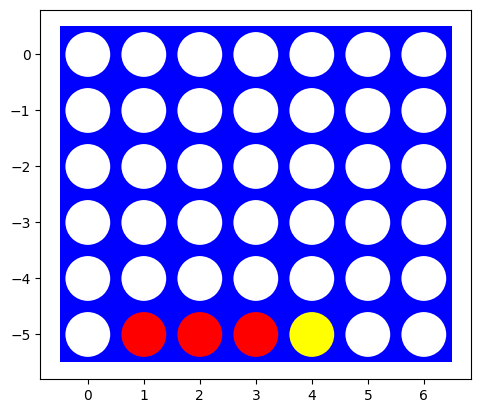

Heuristic agent move (player 1): ('drop', 3)


In [56]:
# Testing on a manually created board:
board_test = empty_board()
board_test[5, 1:4] = 1
board_test[5, 4] = -1
print("Test Board for Heuristic Evaluation:")
visualize(board_test)
# The heuristic_agent function expects a state tuple (board, last_mean)
# We need to provide the last_mean value (False in this case)
print("Heuristic agent move (player 1):", heuristic_agent((board_test, False), 1, depth=4))

How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [57]:
import time

rows, cols = 4, 4
board_test = empty_board(rows, cols)
# Some random discs
board_test[3,0] = 1
board_test[3,1] = -1

start_time = time.time()
move = heuristic_agent((board_test, False), 1, depth=5)
end_time = time.time()

print("Move chosen:", move)
print("Time taken for 4x4, depth=5:", end_time - start_time, "seconds")
rows, cols = 6, 7
board_test_large = empty_board(rows, cols)
# Maybe drop some pieces:
board_test_large[5,3] = 1
board_test_large[4,3] = -1
# etc.

start_time = time.time()
move_large = heuristic_agent((board_test_large, False), 1, depth=5)
end_time = time.time()

print("Move chosen:", move_large)
print("Time taken for 6x7, depth=5:", end_time - start_time, "seconds")


Move chosen: ('drop', 1)
Time taken for 4x4, depth=5: 0.03587079048156738 seconds
Move chosen: ('drop', 3)
Time taken for 6x7, depth=5: 1.5181682109832764 seconds


### Playtime

Let two heuristic search agents (different cutoff depth, different heuristic evaluation function) compete against each other on a reasonably sized board. Since there is no randomness, you only need to let them play once.

In [59]:
def heuristic_agent_depth3(state, player=1):
    return heuristic_agent(state, player, depth=4)

def heuristic_agent_depth5(state, player=1):
    return heuristic_agent(state, player, depth=5)

res = play_game(heuristic_agent_depth3,
                heuristic_agent_depth5,
                rows=6, cols=7,
                n_games=1,
                verbose=True)
print("Heuristic Depth4 vs Depth5:", res)


Heuristic Depth4 vs Depth5: {1: 1, -1: 0, 0: 0}


---
Assignment adapted from [Michael Hahsler](https://github.com/mhahsler/CS7320-AI) under [CC BY-SA](https://creativecommons.org/licenses/by-sa/4.0/deed.en) license.
